Почасовой прогноз

In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

In [417]:
energo = pd.read_csv('result.csv')
energo.head(1)

,Время Мск,"Генерация, МВт*ч\","Потребление, МВт*ч",Местное время в Красноярске,T,Po,U,DD,Ff,N,VV
0,01.01.2019 00:00,24804,25605,01.01.2019 04:00,-23.6,751.0,84.0,"Ветер, дующий с северо-востока",1.0,Облаков нет.,4.0


In [418]:
labels = ['Генерация, МВт*ч\\', 'T', 'Po', 'U', 'Ff', 'VV']
target = 'Потребление, МВт*ч'
names = labels + ['Потребление, МВт*ч']

In [419]:
energo = energo[names]

In [420]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [421]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [422]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [423]:
preemption = 24 * 3

In [424]:
train_x = ([scaler.transform(four_old)[i: i+preemption] for i in range(n_four_old - preemption)] +
    [scaler.transform(three_new)[i: i+preemption] for i in range(n_three_new - preemption)])

In [425]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [426]:
gr_train_x = list(map(np.concatenate, train_x))

In [427]:
train_subs = np.concatenate((scaler.transform(four_old)[preemption-n_four_old:],
    scaler.transform(three_new)[preemption-n_three_new:])).T

In [428]:
train_y = train_subs[-1]

In [429]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [430]:
g_model.fit(gr_train_x, train_y)

MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [431]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


In [432]:
series = scaler.transform(three_new)[-preemption:].T.tolist()

In [433]:
for _ in tqdm.tqdm(range(24*7)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-preemption:]])[0])

100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 676.10it/s]


In [434]:
for _ in tqdm.tqdm(range(24*7)):
    s = np.array([i[-preemption:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2507.53it/s]


In [435]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-24*7-preemption:])]

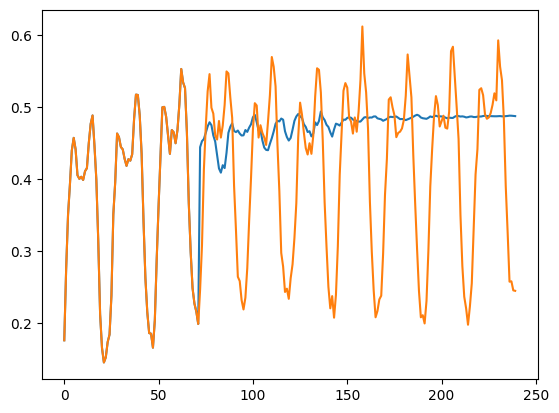

In [436]:
plt.plot(series[-1])
plt.plot(y_true)
plt.show()